In [1]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading

In [2]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [13]:
path = os.path.join(DATA_DIR, 'split_data')

In [14]:
#loading
train_features = pd.read_pickle(os.path.join(path, 'train_features_sensor.pkl'))
test_features = pd.read_pickle(os.path.join(path, 'test_features_sensor_classification.pkl'))
train_labels = pd.read_pickle(os.path.join(path, 'train_labels_classification.pkl'))
test_labels = pd.read_pickle(os.path.join(path, 'test_labels_classification.pkl'))

In [15]:
train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

## FEATURE EXTRACTION WITH PCA

In [16]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

In [17]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 4305) (481, 4305)


In [18]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 235) (481, 235)


In [19]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

### Metrics

In [20]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = auc(recall[i], precision[i])
#         average_precision[i] = auc(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = auc(recall["micro"], precision["micro"])
#     average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["micro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#     roc_auc["macro"] = np.average(list(roc_auc.values()))
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["micro"]

In [21]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## Models

In [22]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [23]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [24]:
# specify runs here
n = 10

### Random Baseline

#### mit shuffling

In [26]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

#### dummy classifiers

%%capture

from sklearn.dummy import DummyClassifier

n=10
strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


### Multi Output Classifier

In [27]:
%%capture

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, forest]

number_of_bootstraps = 10
seed_value = 7

for model in models:
    
    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Multi Output Classifier-'+str(model))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'Multi Output Classifier-'+str(model))

In [28]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))
accuracy_scores

0.09771309771309772 0.253508316008316 1.4092142411642414 0.600309027002657 0.26802733830499026 0.37053912458170507 0.49934131591962116 0.7176812470183327 0.0 0.0071465696465696366 0.009383471933471887 0.010457018545997288 0.01159351477557849 0.013075959943652515 0.0034851458337684937 0.0024883901300049027


[0.033264033264033266, 0.0945945945945946, 0.09771309771309772]

## MLP SIMPLE

In [29]:
%%capture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-1L')

    
    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP-1L')

## MLP complex

In [30]:
%%capture


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-compl')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP-compl')

### Binary Relevance
ignores the possible correlations between class labels

In [31]:
%%capture

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB


a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = BinaryRelevance(GaussianNB())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)


    predicted_labels_br = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_br.toarray())
    
    pr = plot_pr_curve(resampled_ytest, predicted_labels_br.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_br.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Binary relevance')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Binary relevance')

### Classfier Chains

In [32]:
%%capture



from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = ClassifierChain(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_cc = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_cc.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_cc.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_cc.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Classifier Chains')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Classifier Chains')

### Label Powerset
takes correlations into account!

In [33]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-LR')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Powerset-LR')

In [34]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-RFC')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Powerset-RFC')

In [35]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))

0.11538461538461539 0.24207380457380456 1.3661607068607071 0.6251206140350878 0.2840152235965747 0.39057469355469704 0.5154249916017597 0.7238669302810847 0.0031185031185031187 0.0006496881496881463 0.0033058212058213465 0.0019627192982455965 0.0023786869647954567 0.002632360658235744 0.00354188134160055 0.0014274673115513559


### Visualisation

In [36]:
%matplotlib inline

[0.033264033264033266, 0.0945945945945946, 0.09771309771309772, 0.06548856548856549, 0.056133056133056136, 0.0841995841995842, 0.0945945945945946, 0.09251559251559252, 0.11538461538461539] [(0.033264033264033266, 0.033264033264033266), (0.08991683991683992, 0.09927234927234928), (0.09771309771309772, 0.09771309771309772), (0.05145530145530146, 0.07952182952182953), (0.041164241164241167, 0.0711018711018711), (0.07952182952182953, 0.08887733887733888), (0.08991683991683992, 0.09927234927234928), (0.08222453222453223, 0.10280665280665281), (0.11257796257796258, 0.1181912681912682)]


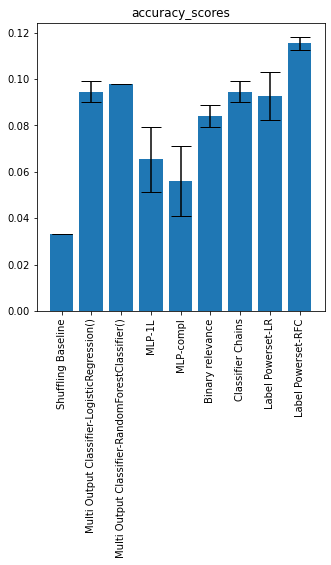

[0.3391372141372141, 0.2692307692307692, 0.253508316008316, 0.3021049896049896, 0.31665800415800416, 0.29235966735966734, 0.26793139293139295, 0.26026507276507277, 0.24207380457380456] [(0.3384355509355509, 0.33983887733887735), (0.2678274428274428, 0.27063409563409563), (0.24707640332640335, 0.2599402286902287), (0.29871361746361746, 0.30549636174636174), (0.3111616424116424, 0.3221543659043659), (0.2888513513513513, 0.29586798336798337), (0.26606029106029105, 0.2698024948024948), (0.2578092515592516, 0.26272089397089393), (0.24148908523908524, 0.2426585239085239)]


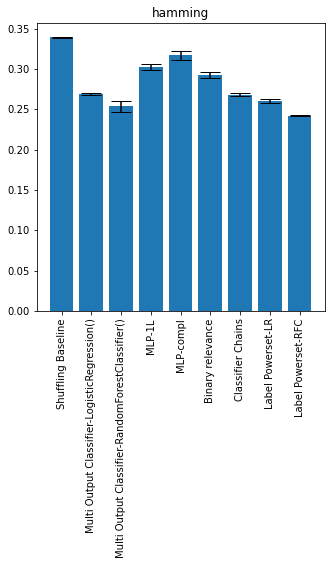

[2.7130977130977127, 1.5109626761973654, 1.4092142411642414, 1.9684106413470466, 2.2593409393187116, 1.8221803631085256, 1.5519985555056177, 1.4953782941737548, 1.3661607068607071] [(2.707484407484407, 2.718711018711019), (1.5086350503152235, 1.5132903020795074), (1.4007691164241167, 1.417659365904366), (1.959284563138445, 1.9775367195556481), (2.181794276658207, 2.336887601979216), (1.7974422320114067, 1.8469184942056445), (1.5498137026558532, 1.5541834083553823), (1.4718819208786327, 1.518874667468877), (1.3631854677754678, 1.3691359459459462)]


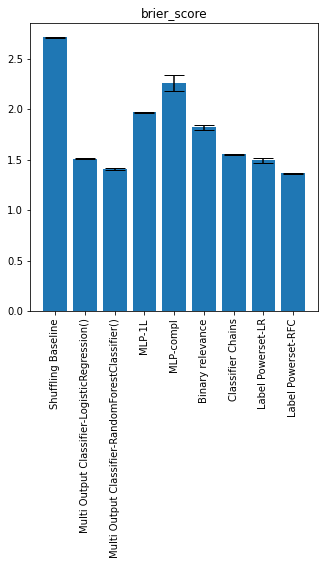

[0.379162702188392, 0.5262578786631722, 0.600309027002657, 0.44503466630849436, 0.4176474730403992, 0.4693476156710281, 0.5322754175590994, 0.5619047619047619, 0.6251206140350878] [(0.37787821122740245, 0.3804471931493815), (0.5111659338517187, 0.5413498234746258), (0.5908977103112594, 0.6097203436940545), (0.44462799963209476, 0.44544133298489397), (0.4157779051987767, 0.4195170408820216), (0.4535181894899178, 0.48517704185213845), (0.5143730525918233, 0.5501777825263754), (0.5576190476190477, 0.5661904761904761), (0.6233541666666667, 0.6268870614035088)]


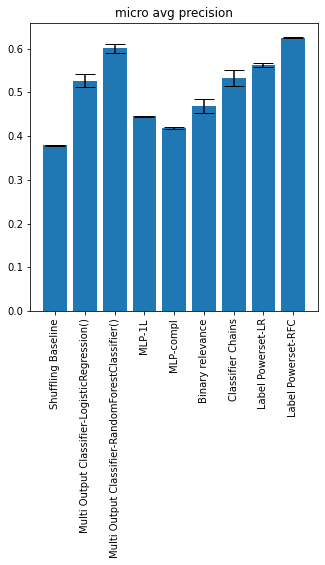

[0.379162702188392, 0.33360137301366044, 0.26802733830499026, 0.3441572867298578, 0.34763250975745746, 0.37704471006412044, 0.3149602732088096, 0.296304798578199, 0.2840152235965747] [(0.37787821122740245, 0.3804471931493815), (0.3310852557847783, 0.33611749024254256), (0.2575931750069696, 0.27846150160301086), (0.3297282286729858, 0.35858634478672985), (0.34699073912740447, 0.34827428038751046), (0.3768588827711179, 0.377230537357123), (0.31386569556732646, 0.3160548508502927), (0.2957916172985782, 0.2968179798578199), (0.2818744053282588, 0.2861560418648906)]


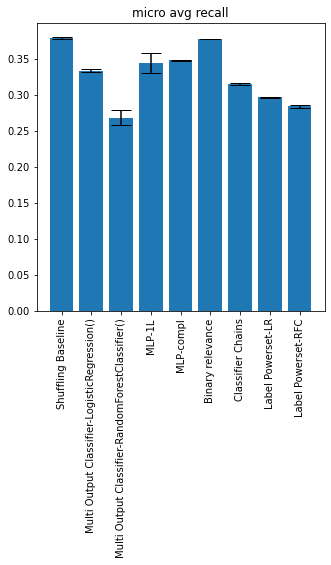

[0.379162702188392, 0.40829321434628885, 0.37053912458170507, 0.38795042610534064, 0.3794325376232486, 0.41801374555731596, 0.39564343317833806, 0.3880018822334343, 0.39057469355469704] [(0.37787821122740245, 0.3804471931493815), (0.4018638041932496, 0.4147226244993281), (0.3587707606324178, 0.38230748853099233), (0.3786152435624114, 0.39728560864826984), (0.37904325376232484, 0.37982182148417226), (0.41184269686978114, 0.42418479424485084), (0.3898288935823841, 0.40145797277429207), (0.38654012630383877, 0.3894636381630298), (0.38820556896228486, 0.3929438181471092)]


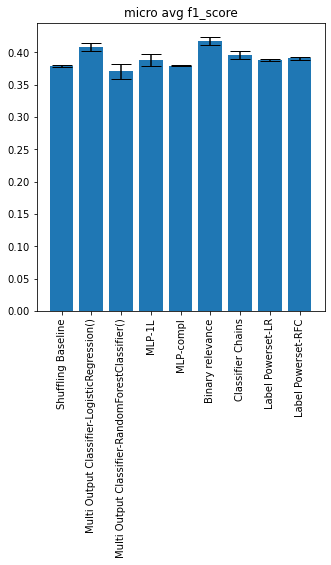

[0.46394700572269554, 0.46159933329177566, 0.49934131591962116, 0.4088479282109336, 0.3925294231851194, 0.40472530901068327, 0.4506589164760899, 0.4720341356514552, 0.5154249916017597] [(0.4628379305621218, 0.4650560808832693), (0.4537766114170899, 0.4694220551664614), (0.4962046846692295, 0.5024779471700128), (0.40297362670273207, 0.4147222297191351), (0.3918784411269308, 0.393180405243308), (0.388538249018221, 0.4209123690031456), (0.442752727237102, 0.45856510571507775), (0.4715203443146058, 0.47254792698830456), (0.5122372983943193, 0.5186126848092002)]


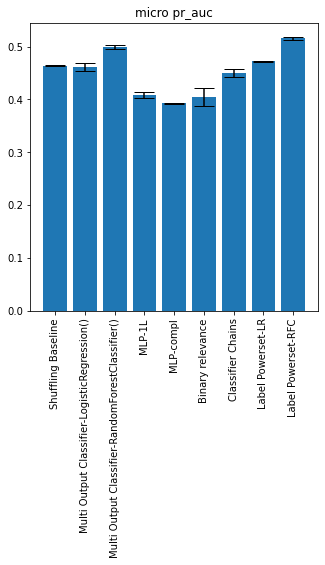

[0.5729385194889046, 0.7038327579229022, 0.7176812470183327, 0.6571459971111981, 0.6193453920170581, 0.6622662679870037, 0.6940566307366863, 0.6976282613962204, 0.7238669302810847] [(0.5720549440119851, 0.5738220949658241), (0.7016809173233352, 0.7059845985224692), (0.7154416959013283, 0.719920798135337), (0.6565889603249305, 0.6577030338974659), (0.6099588858289436, 0.6287318982051725), (0.6571292387788877, 0.6674032971951198), (0.691408605432952, 0.6967046560404206), (0.6935357041767064, 0.7017208186157344), (0.7225822097006885, 0.725151650861481)]


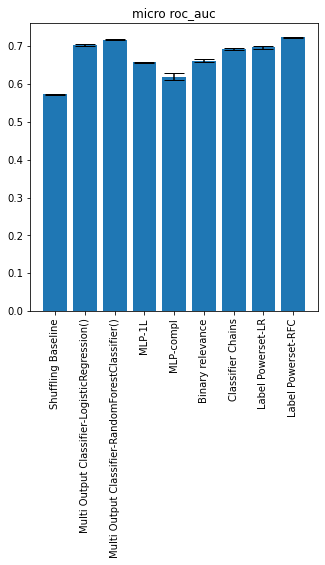

In [37]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()

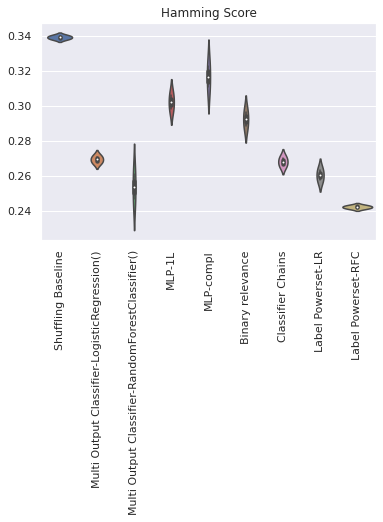

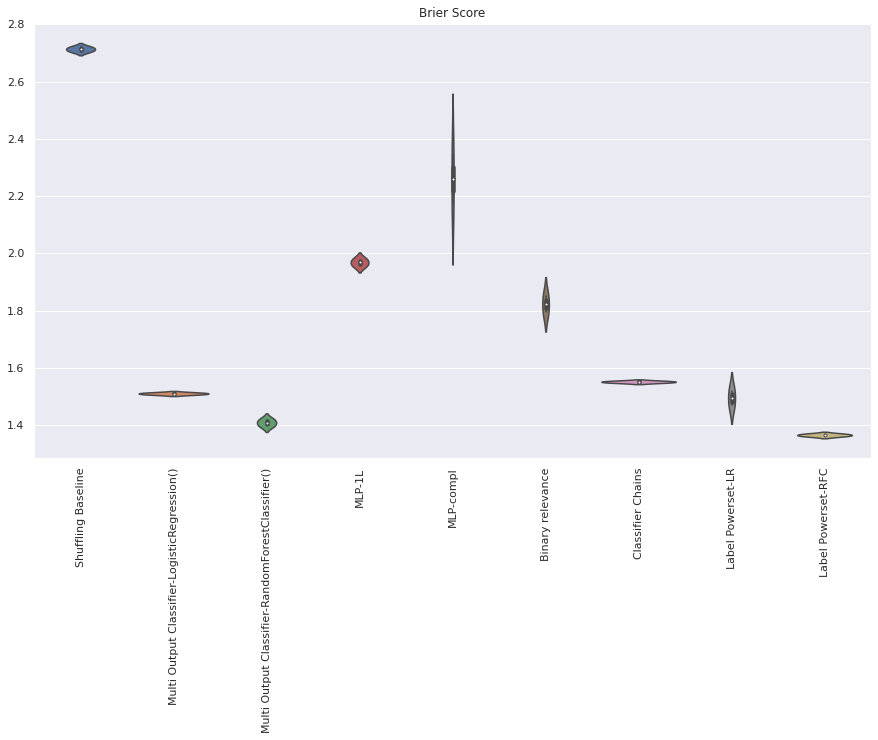

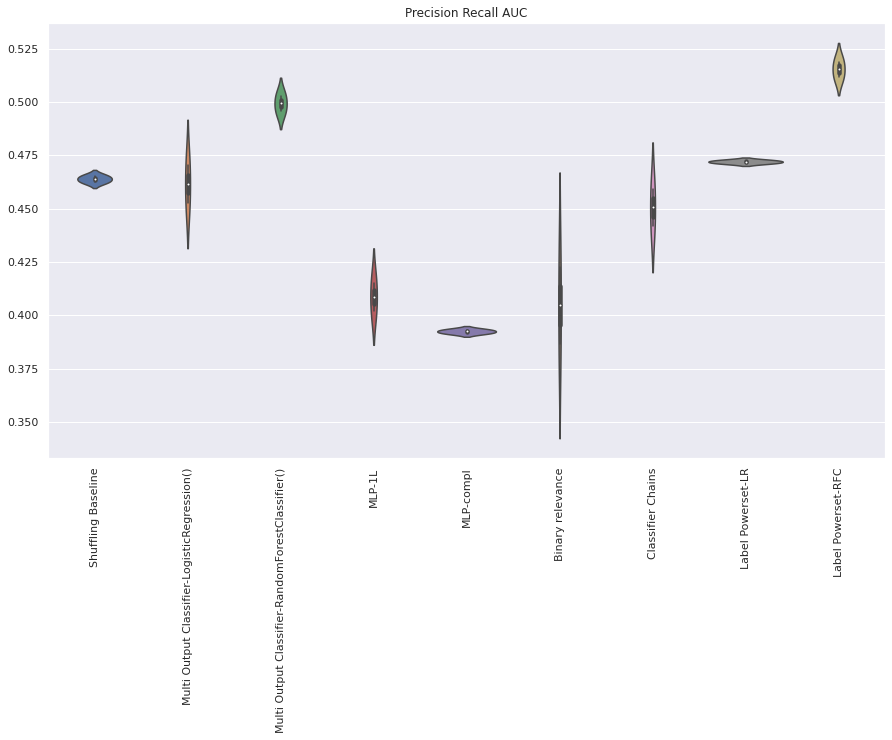

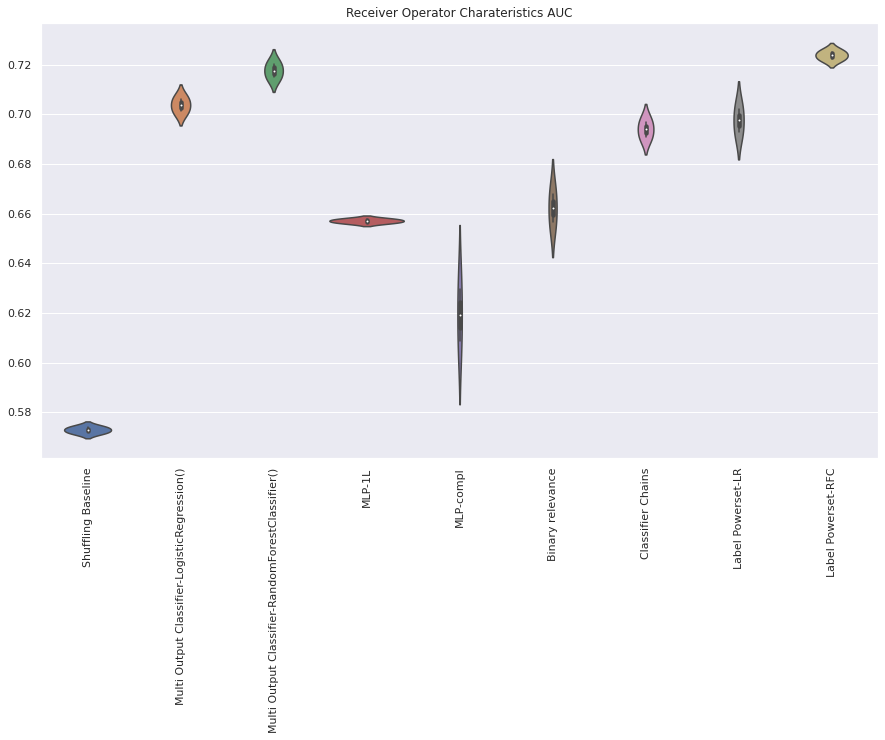

In [38]:
import seaborn as sns
sns.set(style="darkgrid")

# plot
sns.violinplot(y=hamming_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Hamming Score")
plt.show()

# plot
sns.violinplot(y=brier_score_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Brier Score")
plt.show()

# plot
sns.violinplot(y=pr_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Precision Recall AUC")
plt.show()

# plot
sns.violinplot(y=roc_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Receiver Operator Charateristics AUC")
plt.show()